In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.datasets import ImageFolder
import random

Net(
  (conv): Sequential(
    (0): NormActConv(
      (norm_act_conv): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): NormActConv(
      (norm_act_conv): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=294912, out_features=1024, bias=True)
    (1): NormActLin(
      (norm_act_conv): Sequential(
        (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1):

In [2]:
import numpy as np

def oversample(target_class, train_indices, dataset):
    target_class_indices = [idx for idx in train_indices if dataset.samples[idx][1] == target_class]
    print(f"Oversampling klasy: {target_class}, próbki: {len(target_class_indices)}")
    train_indices.extend(target_class_indices)

trans = transforms.Compose(
    [
        transforms.Resize(384),
        transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transNoAugment = transforms.Compose(
    [
        transforms.Resize(384),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


data_dir = "Space"
test_size = 64
batch = 8

dataset = ImageFolder(root=data_dir, transform=transNoAugment)

class_to_indices = {cls: [] for cls in range(len(dataset.classes))}
for idx, (_, label) in enumerate(dataset.samples):
    class_to_indices[label].append(idx)

test_indices = []
train_indices = []

for cls, indices in class_to_indices.items():
    random.shuffle(indices)
    test_indices.extend(indices[:test_size])
    train_indices.extend(indices[test_size:])

oversample(0, train_indices, dataset)

train_dataset = Subset(ImageFolder(root=data_dir, transform=trans), train_indices)
test_dataset = Subset(dataset, test_indices)

trainLoader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
valLoader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

print(f"Liczba danych w zbiorze treningowym: {len(train_dataset)}")
print(f"Liczba danych w zbiorze testowym: {len(test_dataset)}")


Oversampling klasy: 0, próbki: 219
Liczba danych w zbiorze treningowym: 11219
Liczba danych w zbiorze testowym: 448


In [3]:
from collections import Counter

train_labels = [dataset.samples[idx][1] for idx in train_indices]

class_counts = Counter(train_labels)

print("samples per class:")
for cls, count in class_counts.items():
    print(f"Klasa {cls}: {count}")

total_samples = len(train_dataset)
weights = [total_samples / class_counts[cls] for cls in range(len(dataset.classes))]

class_weights = torch.tensor(weights, dtype=torch.float)

print("\nCrossEntropyLoss weights:")
for cls, weight in enumerate(class_weights):
    print(f"Klasa {cls}: {weight:.4f}")

samples per class:
Klasa 0: 438
Klasa 1: 592
Klasa 2: 352
Klasa 3: 2544
Klasa 4: 1128
Klasa 5: 1408
Klasa 6: 4757

CrossEntropyLoss weights:
Klasa 0: 25.6142
Klasa 1: 18.9510
Klasa 2: 31.8722
Klasa 3: 4.4100
Klasa 4: 9.9459
Klasa 5: 7.9680
Klasa 6: 2.3584


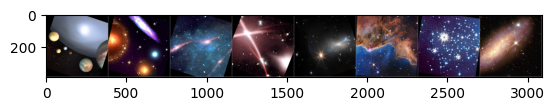

In [4]:
device = torch.device("cuda")

classes = [
    "Asteroid",
    "Black Hole",
    "Comet",
    "Galaxy",
    "Nebula",
    "Planet",
    "Star"
]

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images, labels = next(iter(trainLoader))

imshow(torchvision.utils.make_grid(images))

# print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


In [5]:
class NormActConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.norm_act_conv = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        )

    def forward(self, x):
        return self.norm_act_conv(x)
    

class NormActLin(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.norm_act_conv = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels, out_channels)
        )

    def forward(self, x):
        return self.norm_act_conv(x)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            NormActConv(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            NormActConv(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.linear = nn.Sequential(
            nn.Linear(32*96*96, 1024),
            NormActLin(1024, 256),
            NormActLin(256, 32),
            NormActLin(32, 7)
        )


    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return F.softmax(x, -1)

In [ ]:
from models import Net
net = Net().to(device)

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

eps = 150
load_num = 0

if load_num != 0:
    net.load_state_dict(torch.load(f"models/model_w_{load_num}.pth", weights_only=True))
    optimizer.load_state_dict(torch.load(f"models/opti.pth", weights_only=True))

for epoch in range(eps+1):
    train_loss = 0.0
    val_loss = 0.0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    net.train()
    for i, data in enumerate(trainLoader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    net.eval()
    for i, data in enumerate(valLoader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predictions = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

    gen_acc = 0
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        gen_acc += accuracy
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
    print("General accuracy is: {:.1f} %".format(gen_acc / len(correct_pred)))

    torch.save(net.state_dict(), f"models/model_w_{epoch+load_num+1}.pth")
    torch.save(optimizer.state_dict(), f"models/opti.pth")

    print(f"ep: {epoch+load_num+1}/{eps}, train_loss: {(train_loss/len(trainLoader)):.4f}, val_loss: {(val_loss/len(valLoader)):.4f}")


Accuracy for class Asteroid is: 75.0 %
Accuracy for class Black Hole is: 60.9 %
Accuracy for class Comet is: 45.3 %
Accuracy for class Galaxy is: 71.9 %
Accuracy for class Nebula is: 71.9 %
Accuracy for class Planet is: 53.1 %
Accuracy for class Star  is: 46.9 %
General accuracy is: 60.7 %
ep: 68/150, train_loss: 1.5656, val_loss: 1.5545
Accuracy for class Asteroid is: 68.8 %
Accuracy for class Black Hole is: 60.9 %
Accuracy for class Comet is: 70.3 %
Accuracy for class Galaxy is: 67.2 %
Accuracy for class Nebula is: 68.8 %
Accuracy for class Planet is: 64.1 %
Accuracy for class Star  is: 46.9 %
General accuracy is: 63.8 %
ep: 69/150, train_loss: 1.5702, val_loss: 1.5336
Accuracy for class Asteroid is: 75.0 %
Accuracy for class Black Hole is: 71.9 %
Accuracy for class Comet is: 60.9 %
Accuracy for class Galaxy is: 68.8 %
Accuracy for class Nebula is: 67.2 %
Accuracy for class Planet is: 68.8 %
Accuracy for class Star  is: 37.5 %
General accuracy is: 64.3 %
ep: 70/150, train_loss: 1.557

KeyboardInterrupt: 